### 5. Dataset integration
- requires the above being performed for each of the samples, then combining into a single object and integrating

#### To streamline rerunning on multiple batches:
- I wrote functions to load the csv, make seurat objects, add extra metadata from metadata csv,
  and calculate % mt DNA
- I put plotting functions into a shiny app to make the filter thresholds easy to estimate
- I wrote a function to apply filters

#### Helper functions for loading and processing/integrating
- for longer-term use, I'd put these into a package; for now, I'm sourcing an R file

In [19]:
source('processing_funcs.R')

#### Load and process each batch in turn, and save each seurat object in RDS format
- add metadata, add batch column, calculate mtDNA%, save

In [ ]:
# first, need to extract the mitochondrial gene IDs from a file I downloaded from the
#    ensembl viewer
mt_tab <- fread('mouse_mt_gene_ids.csv')
mt_ids <- mt_tab[gene_id %like% "^ENSMUSG"][,tstrsplit(gene_id, '.', keep=1, fixed=TRUE)][,V1]

# set working dirs
inputdir <- '~/data'
outdir <- '~/working/single_batch'

# per-batch settings
infiles <- c(Arg='Arg_batch1.csv', PJ1='PJ_batch1.csv', PJ2='PJ_batch2.csv')
metafiles <- c(Arg='Arg_batch1_meta.csv', PJ1='PJ_batch1_meta.csv', PJ2='PJ_batch2_meta.csv')
identcols <- c(Arg='stage', PJ1='stage', PJ2='stage')
renamings <- list(Arg=c(celltype='reported_celltype'),
                  PJ1=c(celltype='reported_celltype'),
                  PJ2=c(celltype='reported_celltype')
                 )
colstodrop <- list(Arg=c(1), PJ1=c(1), PJ2=c(1))  # the first column is a sequential index in each file - not wanted
cellidcols <- c(Arg='cell', PJ1='cell', PJ2='cell')
paper <- c(Arg='Arg', PJ1='PJ', PJ2='PJ')

# loop through the batches
for(batch in names(infiles)){
    cat(paste0('\nWorking on: ', batch))
    cat('\nReading data\n')
    s_obj <- seurat_from_csv(file.path(inputdir, infiles[batch]))
    # merge in metadata and fix orig.ident
    s_obj <- add_metacsv(file.path(inputdir, metafiles[batch]),
                         s_obj,
                         cell.id.col=cellidcols[batch],
                         drop=colstodrop[[batch]],
                         ident.col=identcols[batch],
                         slotnames=renamings[[batch]]
                         )
    # add some extra metadata
    s_obj[[]]$paper <- paper[batch]
    s_obj[[]]$batch <- batch

    # add an mt% column to metadata
    cat('Calculating %mtDNA\n')
    s_obj = add_mt_pct(s_obj, mt_ids)

    cat('Saving to an RDS file\n')
    saveRDS(s_obj, file=file.path(outdir, paste0(batch,'.rds')))
    
    # below commented out because of Seurat v5 issues with Seuratdisk
    #cat('Saving to an HDF5 file\n')
    #SeuratDisk::SaveH5Seurat(s_obj, file.path(outdir, batch), overwrite=TRUE)    
    cat('Complete\n')
}   

#### Now I've save seurat objects, I can use my shiny app to examine plots

Run this from a `R` commandline (in tmux to keep it running):  
```
shiny::runApp("~/scRNA/shiny_apps/cell_filter_plots.R", port = 3838, host = "0.0.0.0")
```

Access it at:
https://2b326c3c59d73e49-dot-europe-west2.notebooks.googleusercontent.com/proxy/3838/

### Conclusion:
- The PG datasets seem to have been filtered already, at 5000 reads, and likely also at 1500 genes per cell
- No further cell filtering seems useful
- The Arg1 dataset should be filtered at nCount_RNA >= 50000 & nFeature_RNA >= 150

### Next steps:
1. Load each dataset, filter (where required), normalise and find highly variable genes, and perform PCA
   - use the filter_norm_dimreduct() above (performs SCT normalisation)
   - Seurat handles seperate datasets as layers, and will normalise and find highly variable genes for each
individually and identify a consensus set of variable genes; the function handles this.
2. Save the combined dataset file
2. Examine number of important components for each sample, and uMAP and plot seperately
3. Integrate

#### Load, filter, combine into a single object & save

In [2]:
# set working dir
inputdir <- '~/working/single_batch'
outdir <- '~/working/combined'

# per-batch filter settings
filter_args <- list(Arg='nCount_RNA >= 50000 & nFeature_RNA >= 150', PJ1=NULL, PJ2=NULL)

# load batch objects into list
s_obj_list = list()
for(batch in names(filter_args)){
    cat(paste0('Loading batch ', batch, '\n'))
    s_obj_list[[batch]] <- readRDS(file=file.path(inputdir, paste0(batch,'.rds')))
}
cat('\n')

# run my function (from file sourced above) to apply filters, combine files, SCT normalise, run pca
s_obj <- filter_norm_dimreduct(s_obj_list, filter_args)

cat('Saving file\n')
saveRDS(s_obj, file=file.path(outdir, 'combined_unintegrated.rds'))


Loading batch Arg
Loading batch PJ1
Loading batch PJ2

Filtering Arg
Filtering PJ1
No filter supplied for PJ1
Filtering PJ2
No filter supplied for PJ2
Combining into single object
Normalising and finding highly variable features


Running SCTransform on assay: RNA

Running SCTransform on layer: counts.1

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.



In [4]:
s_obj

An object of class Seurat 
50042 features across 19108 samples within 2 assays 
Active assay: SCT (20479 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

### Integration
- there are lots of ways to integrate; for now, just try CCA, but long-term would investigate SCVI, and perhaps others

In [9]:
outdir <- '~/working/combined'
s_obj <- readRDS(file.path(outdir, 'combined_unintegrated.rds'))

In [10]:
s_obj <- IntegrateLayers(
  object = s_obj,
  method = CCAIntegration,
  normalization.method = "SCT",
  new.reduction = "integrated.cca",
  verbose = FALSE
)

In [12]:
s_obj <- IntegrateLayers(
  object = s_obj,
  method = HarmonyIntegration,
  orig.reduction = "pca", new.reduction = "integrated.harmony",
  normalization.method = "SCT",
  verbose = FALSE
)

In [13]:
s_obj

An object of class Seurat 
50042 features across 19108 samples within 2 assays 
Active assay: SCT (20479 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, integrated.cca, integrated.harmony

In [14]:
saveRDS(s_obj, file=file.path(outdir, 'integrated.rds'))

In [5]:
outdir <- '~/immunocore/working/combined'
s_obj <- readRDS(file.path(outdir, 'integrated.rds'))

Having integrated, let's have a look at how well the different integrations worked
- make and plot umap projections for each integration

In [16]:
test <- FindNeighbors(object = s_obj, reduction = 'pca', graph.name = 'pca.knn', dims = 1:30)

Computing nearest neighbor graph

Computing SNN

Only one graph name supplied, storing nearest-neighbor graph only



In [17]:
test <- FindClusters(object = test, graph.name = 'pca.knn', cluster.name = 'pca.leiden', algorithm = 4, resolution = 1)

Warning message in RunLeiden(object = object, method = method, partition.type = "RBConfigurationVertexPartition", :
“`random.seed` must be greater than 0 for leiden clustering, resetting `random.seed` to 1.”


In [ ]:
test <- RunUMAP(object = test, dims = 1:30, reduction = 'pca', reduction.name = 'pca.umap')


In [20]:
s_obj <- nn_leiden_umap(s_obj, reduction='pca')
s_obj <- nn_leiden_umap(s_obj, reduction='integrated.cca')
s_obj <- nn_leiden_umap(s_obj, reduction='integrated.harmony')

Computing nearest neighbor graph

Computing SNN

Only one graph name supplied, storing nearest-neighbor graph only

Warning message in RunLeiden(object = object, method = method, partition.type = "RBConfigurationVertexPartition", :
“`random.seed` must be greater than 0 for leiden clustering, resetting `random.seed` to 1.”
14:05:40 UMAP embedding parameters a = 0.9922 b = 1.112

14:05:40 Read 19108 rows and found 30 numeric columns

14:05:40 Using Annoy for neighbor search, n_neighbors = 30

14:05:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:05:42 Writing NN index file to temp file /var/tmp/RtmpFvRymw/file21b316c7aae4

14:05:42 Searching Annoy index using 1 thread, search_k = 3000

14:05:50 Annoy recall = 100%

14:05:51 Commencing smooth kNN distance calibratio

In [34]:
saveRDS(s_obj, file=file.path(outdir, 'integrated.rds'))

In [32]:
s_obj

An object of class Seurat 
50042 features across 19108 samples within 2 assays 
Active assay: SCT (20479 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 6 dimensional reductions calculated: pca, integrated.cca, integrated.harmony, pcaumap, integrated.ccaumap, integrated.harmonyumap

### Compare integrations: note that stages E4.5 and E5.5 are in Arg only, whereas E6.5 and E7.5 are in all batches

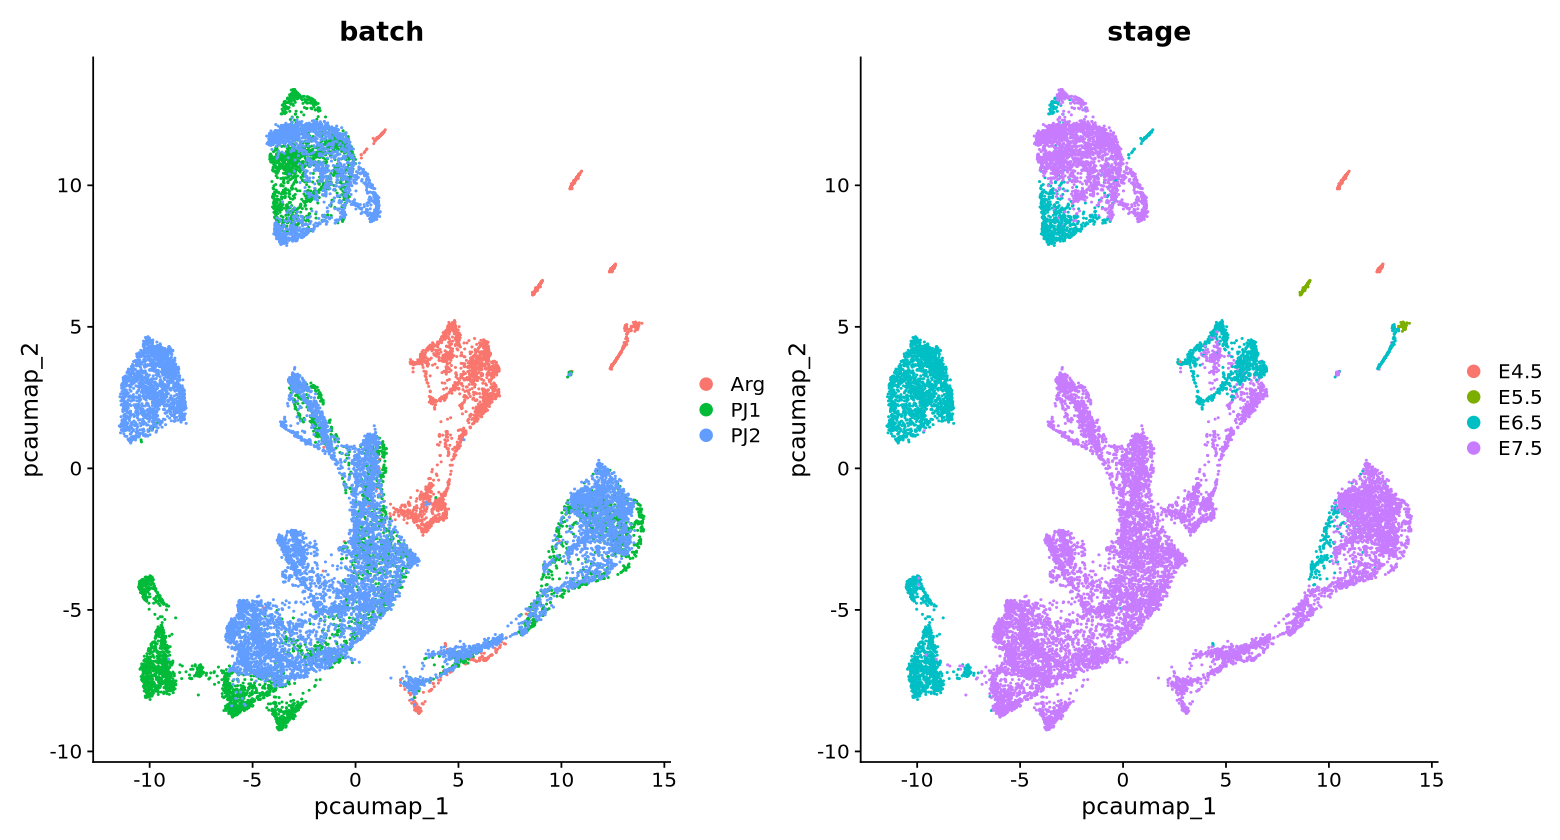

In [24]:
# unintegrated
options(repr.plot.width = 13, repr.plot.height = 7)
DimPlot(s_obj, reduction = "pcaumap", group.by = c("batch", "stage"))

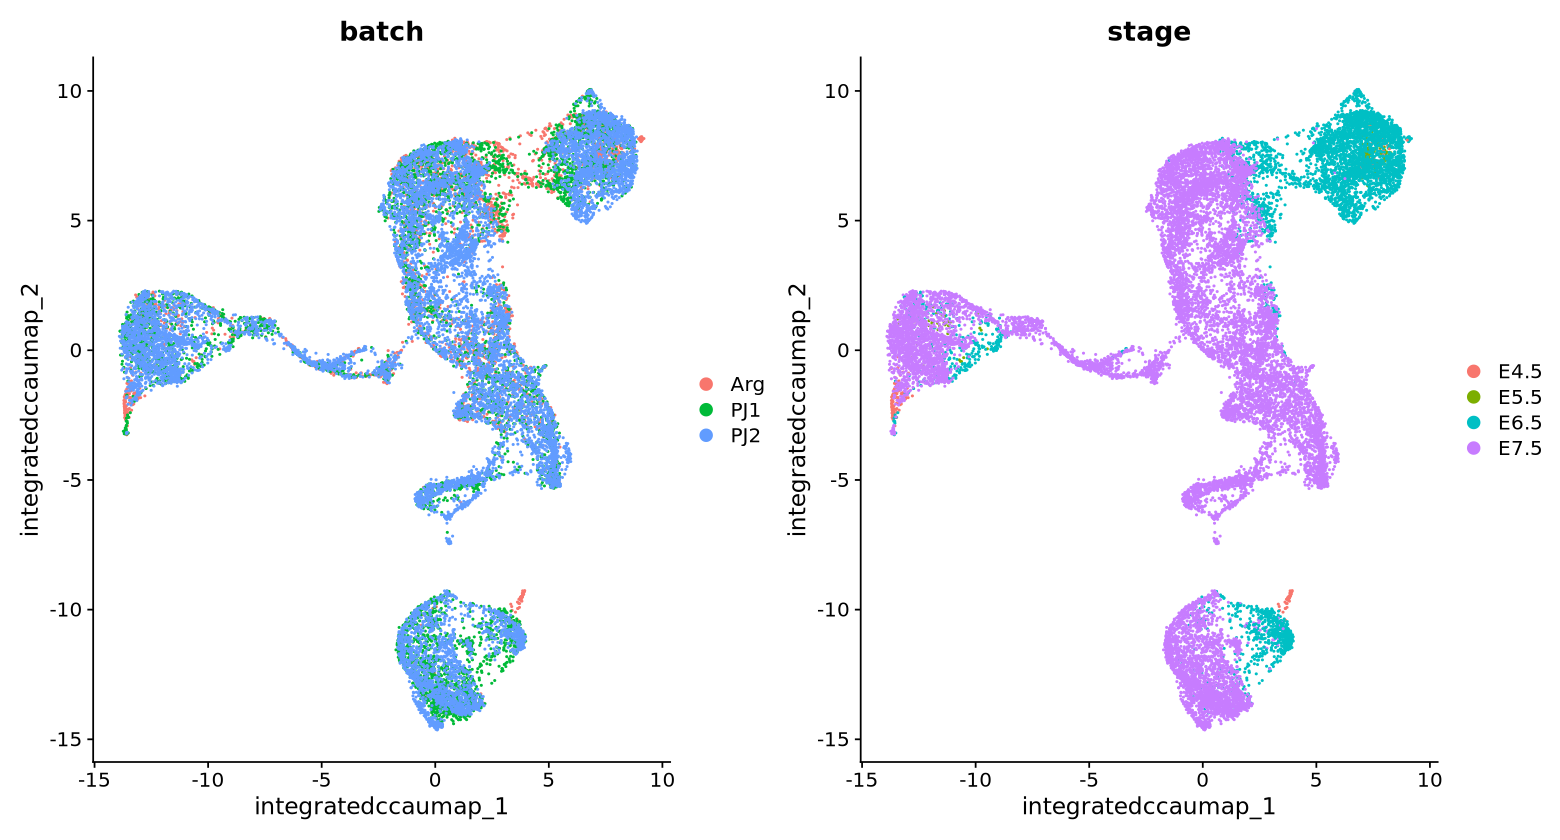

In [25]:
# CCA integrated
options(repr.plot.width = 13, repr.plot.height = 7)
DimPlot(s_obj, reduction = "integrated.ccaumap", group.by = c("batch", "stage"))

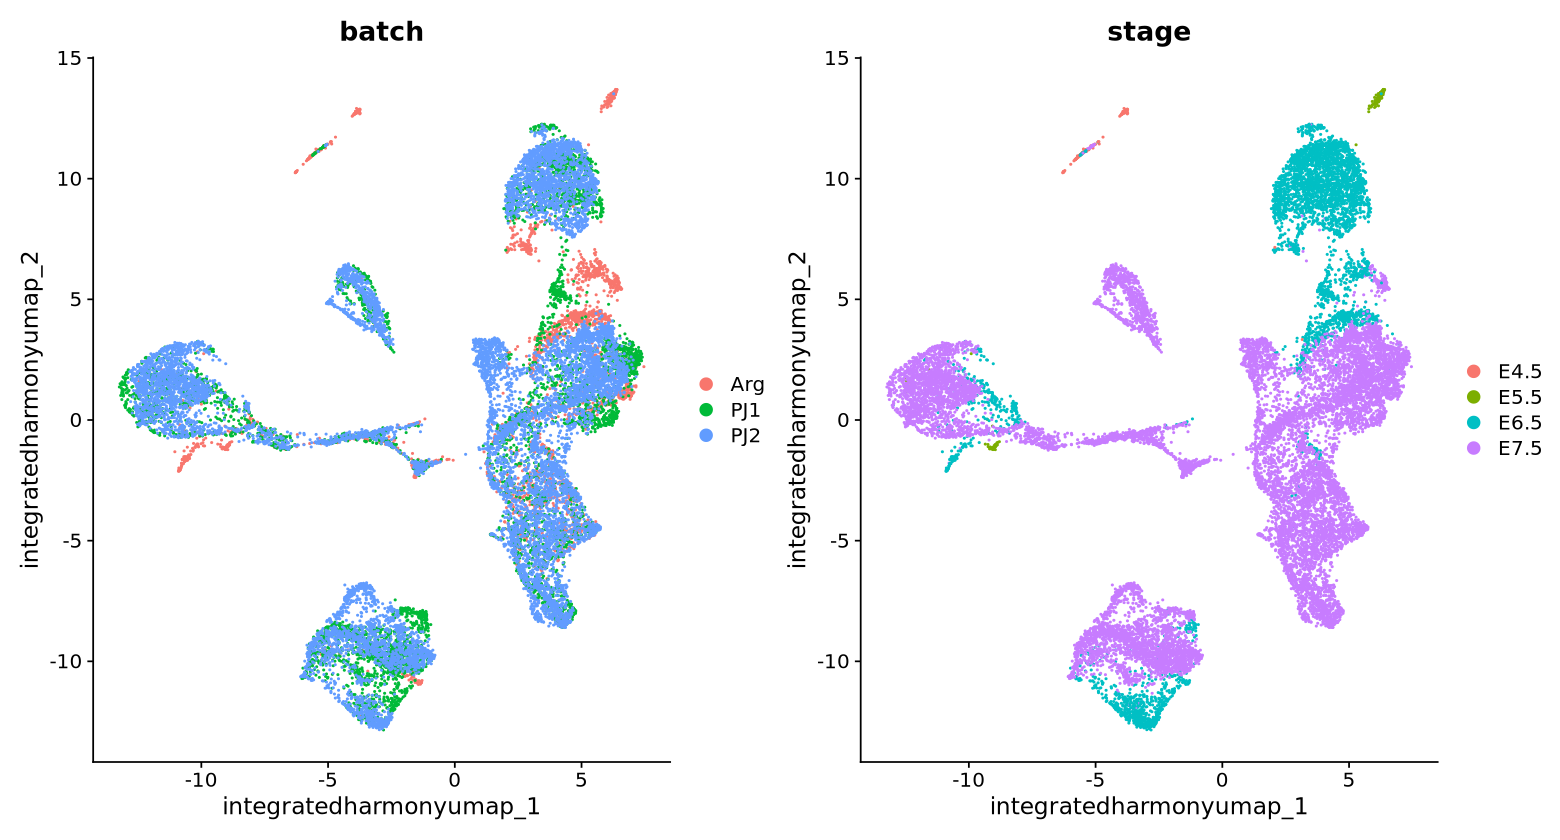

In [26]:
# Harmony integrated
options(repr.plot.width = 13, repr.plot.height = 7)
DimPlot(s_obj, reduction = "integrated.harmonyumap", group.by = c("batch", "stage"))


Batch integration looks pretty good.
Would also like to use a NN-based approach: attempts to get scVI integration to work from within Seurat were unsuccessful, and 
searching bug reports and the web suggests that the functionality within Seurat is very immature; I would proceed in python for this.
- Harmony integration appears to seperate out a population for E5.5, wheras CCA integration does not - obviously more work is required to validate